<a href="https://colab.research.google.com/github/CoolerKula/Introduction-To-Computer-Vision/blob/main/Introduction_To_Computer_Vision_project_Bernard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**

The supermarket chain would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. You are asked to conduct that evaluation, so as you set to work, keep the following in mind:

● The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol.

● Computer vision methods can be used to determine the age of a person from a photo.

● The task then is to build and evaluate a model for verifying people's age.
To start working on the task, you'll have a set of photographs of people with their ages indicated.

**Project Instructions**

● Before getting your hands dirty with the project, let's think of the Good Seed supermarket task in detail. Imagine your manager wants to check your understanding of the task.
Pass this quiz to verify your understanding of the project statement.

● Perform exploratory data analysis to get an overall impression of the dataset.

● Train and evaluate the model (it needs to be done on the GPU platform).

● Combine your code, output, and findings (from the previous points) in the final notebook.

● Make conclusions of the model evaluation, add them to the notebook.
Data description

Download the dataset for this project here [link].

As the number of image files is rather high, it is advisable to avoid reading them all at once, which would be resource-consuming, and to read them sequentially with the ImageDataGenerator generator. This method was explained in Data Generators.

In [ ]:
#necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load labels.csv and observe it
labels = pd.read_csv('../input/appa-real-face-cropped/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


> Let's qucikly check the age distribution of photos

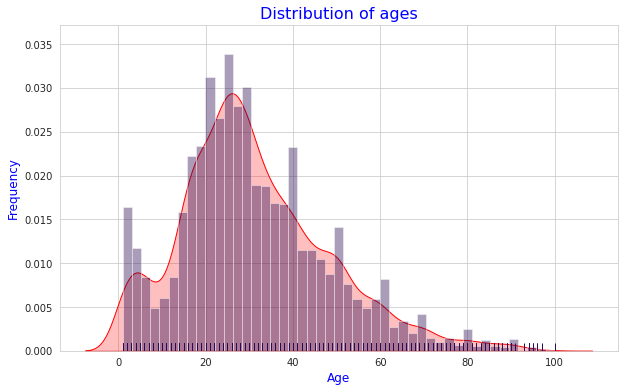

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.set_palette('inferno')
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Age', fontsize=12, color='b')
plt.ylabel('Frequency', fontsize=12, color='b')
plt.title('Distribution of ages', fontsize=16, color='b')
plt.show()

*As we can see from the above plot, we have images of people of various ages. However, the majority of the images belong to 20-40 years old people. And also we have pretty much cute baby photos (less than 10).*

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. Hence, we will use the **ImageDataGenerator** generator: class from Keras, that forms batches with images and labels (class for classification, for instance) based on the photos in a directory.

In [ ]:
# create datagenerator object for training and validation datasets
#rescale images using 1/255
train_datagen = ImageDataGenerator(
            #we will do normalization for image pixel values as following
            rescale=1 / 255
            )

#use flow_from_dataframe method to load images from directory and labels from dataframe
train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = labels,
    directory='../input/appa-real-face-cropped/final_files/final_files',
    x_col="file_name", 
    y_col="real_age",
    #we are doing regression, so we will assign class_mode to 'raw'
    class_mode="raw",
    #to convert all images to same pixel size, for neural networks, all images should have similar size
    target_size=(224,224),
    #we will load images batch by batch (every time 32 images will be loaded)
    batch_size=32,
    seed=12345,
    )

Found 7591 validated image filenames.


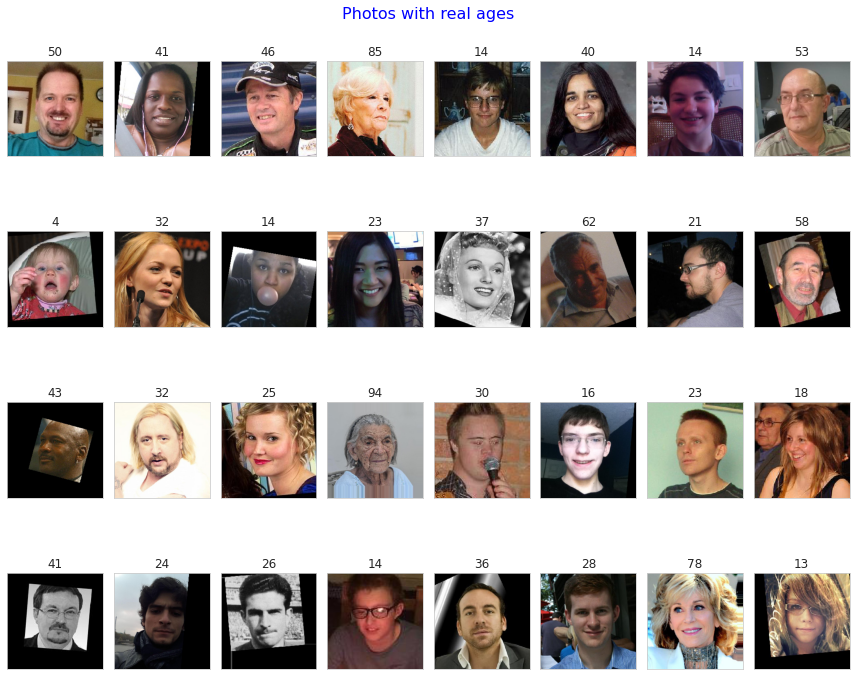

In [ ]:
#get one batch from our datagenerator and display images in it
features, target = next(train_datagen_flow)

# display 16 images
fig = plt.figure(figsize=(12,12))
for i in range(32):
    fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
	# remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Photos with real ages',  y=0.9,fontsize=16, color='b')
    plt.tight_layout()

As we can see, our dataset contains various face photos. Some of them rotated, shifted etc a little bit. Can you guess the age looking the photos :). Now, we will train a model, telling them what is the age, and then ask them to guess (using validation dataset).

## 2. Defining necessary functions for neural network

In [ ]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv(path + 'labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'final_files/final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape):
    
    """
    It defines the model
    """
    # we will use ResNet50 architecture, with freezing top layers
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    
    #now we will add our custom layers
    #without drop layer, neural networks can easily overfit
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    
    #final layer, since we are doing regression we will add only one neuron (unit)
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    print(model.summary())

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

## Calling functions

In [ ]:
#assign data directory
path = '../input/appa-real-face-cropped/'

In [ ]:
#load training and testing (actually this is validation data set)
train_data = load_train(path)
test_data = load_test(path)

#build a model
model = create_model(input_shape = (224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.
94773248/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


> Training model can take long time, especillay without GPU. Therefore, we strongly recommend to turn on your GPU before next step. By the way, there are more than 23 million trainable parameters in the ResNet50 model. This is the reason why using it without a GPU platform would cause a very, very long wait time for a model to be trained, even if it has been pre-trained.

In [ ]:
#train the model
model = train_model(model, train_data, test_data)

Epoch 1/20
178/178 - 84s - loss: 10.6568 - mae: 10.6568 - val_loss: 13.0804 - val_mae: 13.0804
Epoch 2/20
178/178 - 53s - loss: 7.7782 - mae: 7.7782 - val_loss: 18.4718 - val_mae: 18.4718
Epoch 3/20
178/178 - 53s - loss: 6.6656 - mae: 6.6656 - val_loss: 15.2613 - val_mae: 15.2613
Epoch 4/20
178/178 - 53s - loss: 5.9409 - mae: 5.9409 - val_loss: 9.3930 - val_mae: 9.3930
Epoch 5/20
178/178 - 53s - loss: 5.5409 - mae: 5.5409 - val_loss: 12.1452 - val_mae: 12.1452
Epoch 6/20
178/178 - 54s - loss: 4.9665 - mae: 4.9665 - val_loss: 6.7697 - val_mae: 6.7697
Epoch 7/20
178/178 - 53s - loss: 4.8135 - mae: 4.8135 - val_loss: 7.3841 - val_mae: 7.3841
Epoch 8/20
178/178 - 53s - loss: 4.3120 - mae: 4.3120 - val_loss: 7.1672 - val_mae: 7.1672
Epoch 9/20
178/178 - 54s - loss: 4.0352 - mae: 4.0352 - val_loss: 7.7899 - val_mae: 7.7899
Epoch 10/20
178/178 - 53s - loss: 3.8823 - mae: 3.8823 - val_loss: 6.8987 - val_mae: 6.8987
Epoch 11/20
178/178 - 52s - loss: 3.4197 - mae: 3.4197 - val_loss: 6.6848 - val

## We have achieved quite good MAE, which can predict age of person with $\pm$ 6.4. 

## By the way, in [one article about this dataset](http://people.ee.ethz.ch/~timofter/publications/Agustsson-FG-2017.pdf) we are working with, the lowest MAE value reached is 5.4. This paper was published in 2017 by ETH Computer Vision researhcer. We also did quite well by getting MAE of 6.4 compared to 5.4.

So our XYZ store, now can use this model just to idenify the age of person who is buying an alcohol products.